-----------
Initializing structure...
time for choose_chunkdivision = 0.00346279 s
Working in 2D dimensions.
Computational cell is 17 x 17 x 0 with resolution 40
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (-6,1.73205,0)
          radius 0.22, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.5,2.59808,0)
          radius 0.22, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5,3.4641,0)
          radius 0.22, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-4.5,4.33013,0)
          radius 0.22, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6,0,0)
          radius 0.22, height 1e+20,

FloatProgress(value=0.0, description='0% done ', max=300.0)

Meep progress: 23.5/300.0 = 7.8% done in 4.0s, 47.1s to go
on time step 1883 (time=23.5375), 0.0021252 s/step
Meep progress: 58.75/300.0 = 19.6% done in 8.0s, 32.9s to go
on time step 4706 (time=58.825), 0.00141707 s/step
Meep progress: 95.95/300.0 = 32.0% done in 12.0s, 25.5s to go
on time step 7680 (time=96), 0.00134913 s/step
Meep progress: 132.3125/300.0 = 44.1% done in 16.0s, 20.3s to go
on time step 10601 (time=132.513), 0.0013697 s/step
Meep progress: 168.8375/300.0 = 56.3% done in 20.0s, 15.5s to go
on time step 13525 (time=169.062), 0.00136805 s/step
Meep progress: 205.8125/300.0 = 68.6% done in 24.0s, 11.0s to go
on time step 16480 (time=206), 0.00135719 s/step
Meep progress: 242.525/300.0 = 80.8% done in 28.0s, 6.6s to go
on time step 19430 (time=242.875), 0.00135624 s/step
Meep progress: 279.1375/300.0 = 93.0% done in 32.0s, 2.4s to go
on time step 22359 (time=279.488), 0.00136578 s/step
run 0 finished at t = 300.0 (24000 timesteps)
Saved image: hex_pc_defect_ez.png


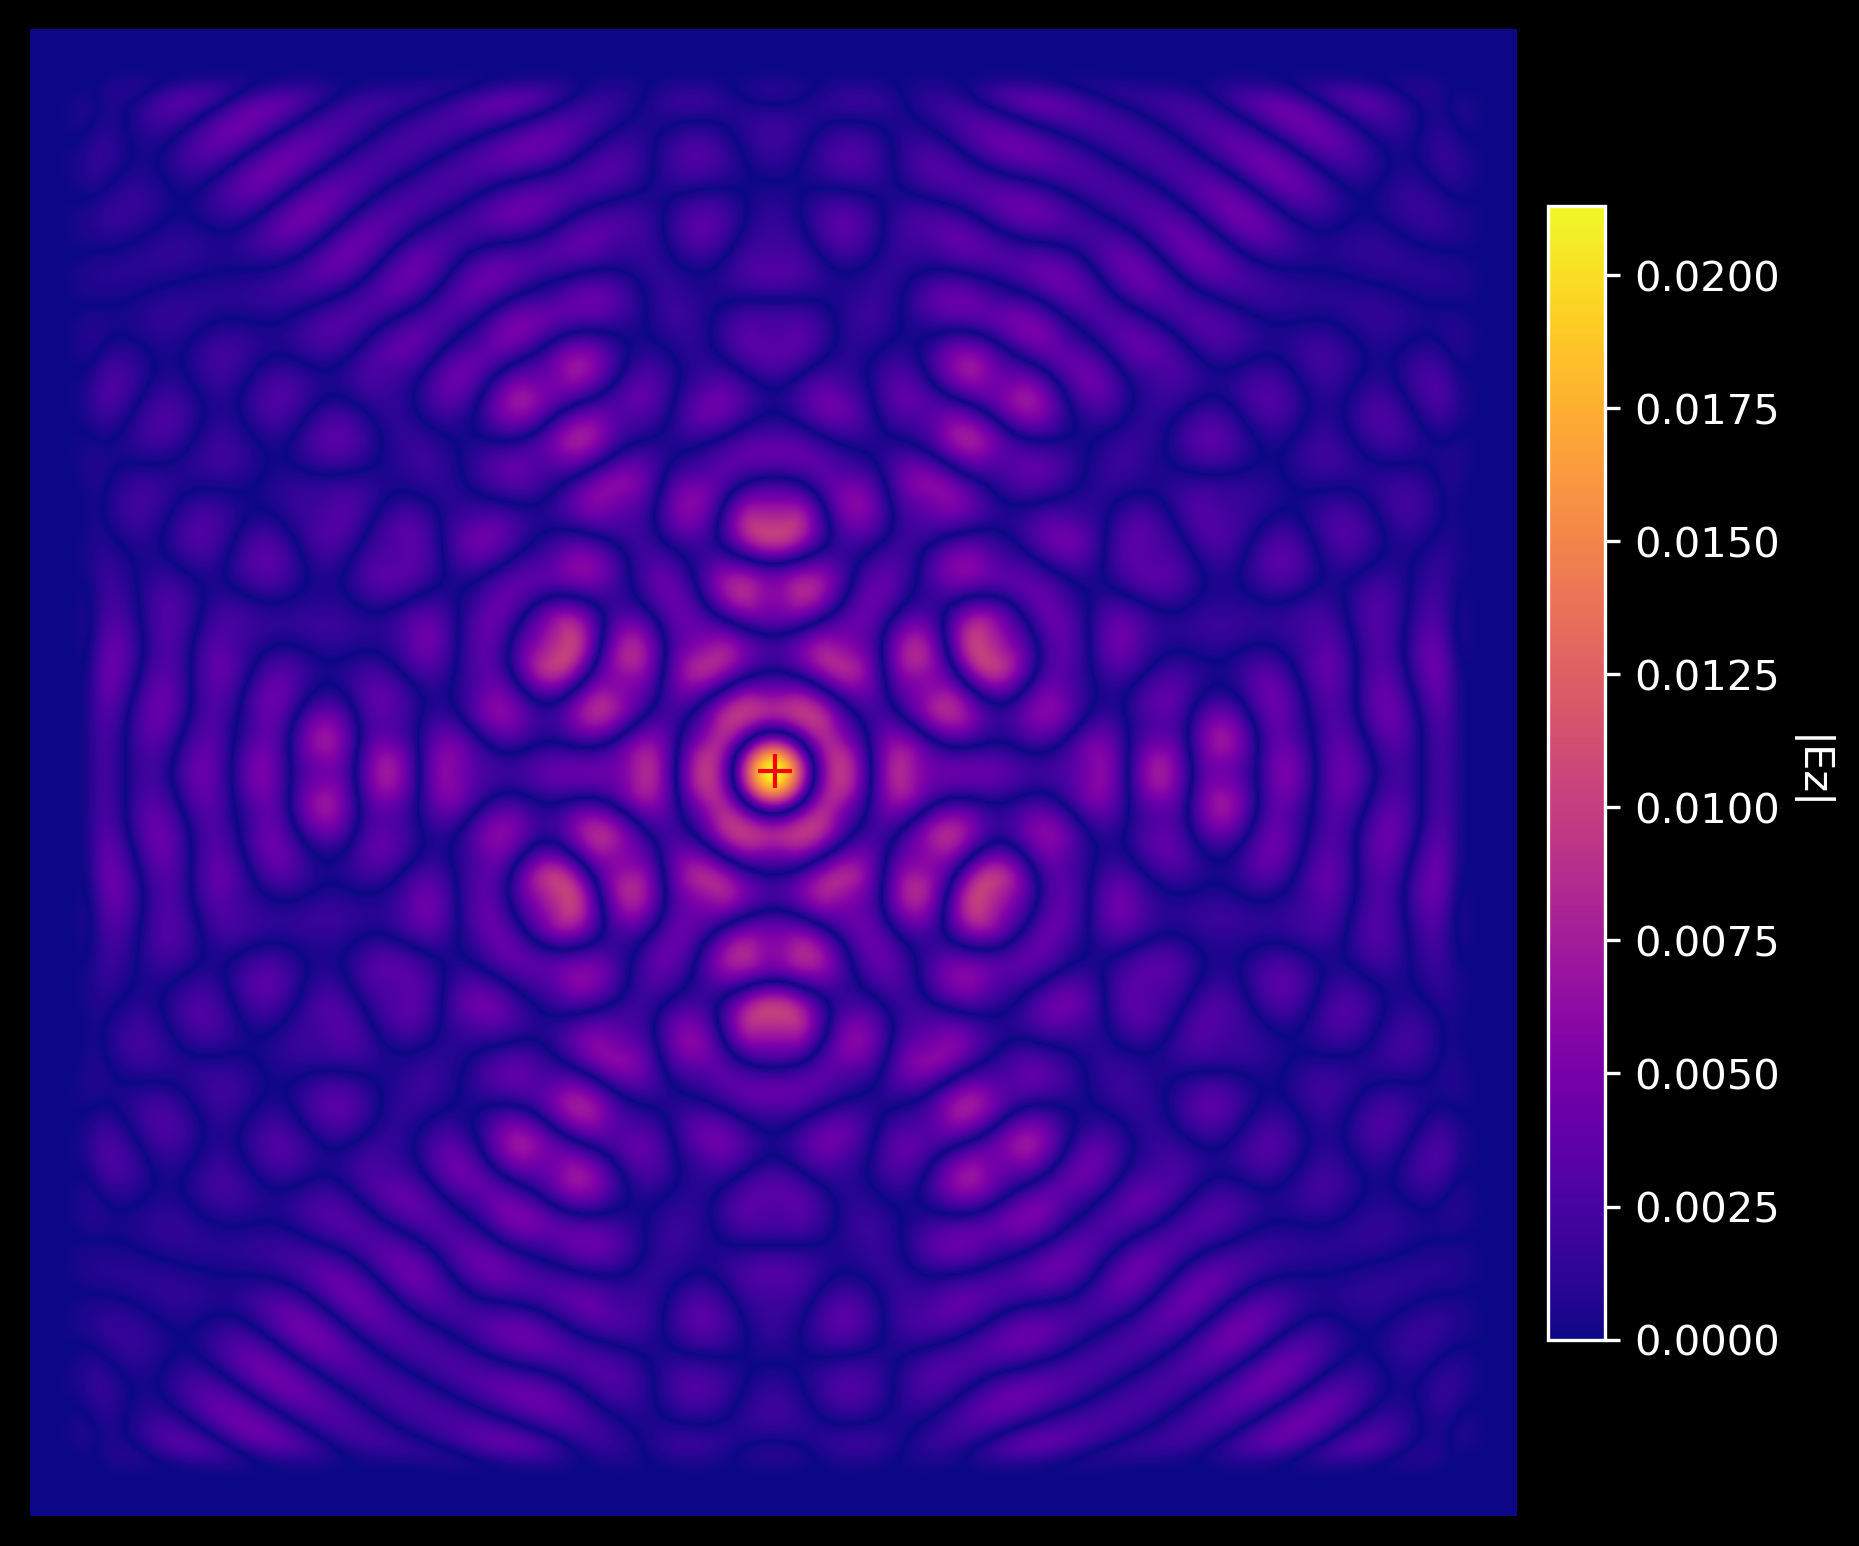

In [2]:
# 六角光子晶體+缺陷腔
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# -----------------------------
# 參數（可調）
a = 1.0                 # 晶格常數
r_hole = 0.22 * a       # 孔半徑
N = 7                   # 發展範圍：從 -N..N 的格點（晶體半徑約）
slab_index = 3.4        # 基底折射率 (高介電常數)
resolution = 40         # 空間解析度 (px/單位長度)。比賽建議 30~80
pml_thickness = 1.0

# Derived simulation size (選取能包住晶格的方形區域)
Lx = (2*N + 3) * a
Ly = (2*N + 3) * a
cell = mp.Vector3(Lx, Ly, 0)

# PML
pml_layers = [mp.PML(pml_thickness)]

# -----------------------------
# 幾何：基底為介電 slab（2D 模擬視為無限厚）
background = mp.Block(size=mp.Vector3(mp.inf, mp.inf, mp.inf),
                      material=mp.Medium(index=slab_index))

geometry = [background]  # 我們以孔洞覆蓋在基底上（以 air 圓柱表示）

# 六角（實際為三角格子）格點座標的基底向量
a1 = np.array([a, 0.0])
a2 = np.array([0.5 * a, math.sqrt(3)/2 * a])

# 放置空氣孔：在一定半徑內放孔，並在中心移除來形成缺陷腔
max_radius = (N - 0.5) * a  # 邊界控制
defect_radius = 0.6 * a     # 中心缺陷半徑：在此半徑內不放孔

for i in range(-N, N+1):
    for j in range(-N, N+1):
        pos = i * a1 + j * a2
        x, y = pos[0], pos[1]

        # 只放在圓形截面內，避免切到 PML
        if np.hypot(x, y) <= max_radius:
            # 若在 defect_radius 內 -> 當作缺陷（skip），即保留空間
            if np.hypot(x, y) <= defect_radius:
                continue
            # 否則放一個 air 柱（在基底中挖孔）
            geometry.append(
                mp.Cylinder(radius=r_hole, height=mp.inf,
                            center=mp.Vector3(x, y), material=mp.air)
            )

# -----------------------------
# 光源（中心缺陷內放一個脈衝源，方便展現腔模）
f0 = 0.25              # 中心頻率（可微調以找到共振）
df = 0.1               # 脈衝頻寬
src = mp.Source(mp.GaussianSource(f0, fwidth=df),
                component=mp.Ez,
                center=mp.Vector3(0, 0),
                size=mp.Vector3(0, 0, 0))  # 點源

sources = [src]

# -----------------------------
# 建立模擬
sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution,
                    dimensions=2)

# -----------------------------
# 存取若干時間點的場（或只存最後一幀）
frames = []
def store_frame(sim):
    ez = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
    frames.append(np.copy(ez))

# 執行：用 mp.at_every 捕獲多張幀，或直接跑到穩態再存一張
t_end = 300  # 模擬總時間（視頻率/解析度可增大）
dt_store = 2  # 每 2 時間單位存一張幀
sim.run(mp.at_every(dt_store, store_frame), until=t_end)

# -----------------------------
# 視覺化：取最後一幀場的幅值（|Ez|）
ez_final = frames[-1]
abs_ez = np.abs(ez_final)

# 為了輸出清晰圖片，我們把物理座標轉成像素座標以便疊上孔洞輪廓
ny, nx = abs_ez.shape  # numpy array shape: (rows(y), cols(x))
# 建立繪圖
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(6,6), dpi=300)

# 固定色標（用於動畫或多張比較時保持一致）
vmax = abs_ez.max()
im = ax.imshow(abs_ez, origin='lower', cmap='plasma', vmin=0, vmax=vmax)

# 標註中心
ax.plot((0 + cell.x/2)*(nx/cell.x), (0 + cell.y/2)*(ny/cell.y), 'r+', markersize=8)

ax.axis('off')
cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.02)
cbar.set_label('|Ez|', rotation=270, labelpad=12)

plt.tight_layout(pad=0)
out_fname = "hex_pc_defect_ez.png"
plt.savefig(out_fname, dpi=600, bbox_inches='tight', pad_inches=0)
print(f"Saved image: {out_fname}")

plt.show()
